In [1]:
import tensorflow
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, BatchNormalization, ReLU, Conv2D, Dense, MaxPool2D, AvgPool2D, GlobalAvgPool2D, Concatenate

##############
import os

from os import listdir
from os.path import isfile, join
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import Xception

In [2]:
currentPath = os.getcwd()
print(currentPath)

C:\Users\CARLOS CORDERO\Desktop\ToG_pretrain


In [3]:
gpus = tensorflow.config.experimental.list_physical_devices('GPU')
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


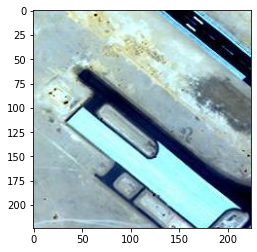

In [4]:
trainDB = currentPath + os.sep + "train20"
valDB = currentPath + os.sep + "val20"
data_set_path = currentPath + os.sep + "fMoW" + os.sep
XceptionWeightsPretrained = currentPath + os.sep + "xception_weights_tf_dim_ordering_tf_kernels_notop.h5"
model_name = "Xception"
classList = os.listdir(trainDB)

img = mpimg.imread(trainDB + os.sep + "airport" + os.sep + "airport_18_0_msrgb.jpg")
imgplot = plt.imshow(img)

In [5]:
lr = 0.00004
batch_size = 10
num_epochs = 100
pre_train_epochs = 20

num_steps_per_epoch = 4
img_rows, img_cols, img_channel = 299, 299, 3
num_categories = len(classList)

In [6]:
train_data_gen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=270,
    zoom_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')
    
train_generator = train_data_gen.flow_from_directory(
    directory=trainDB,
    target_size=(img_cols, img_rows),
    batch_size=batch_size,
    class_mode='categorical'
)

val_data_gen = ImageDataGenerator(
    rescale=1. / 225,
)
val_generator = val_data_gen.flow_from_directory(
    directory=valDB,
    target_size=(img_cols, img_rows),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 925 images belonging to 62 classes.
Found 309 images belonging to 62 classes.


In [7]:
print(train_generator.class_indices)
imgs, labels = next(train_generator)

{'airport': 0, 'airport_hangar': 1, 'airport_terminal': 2, 'amusement_park': 3, 'aquaculture': 4, 'archaeological_site': 5, 'barn': 6, 'border_checkpoint': 7, 'burial_site': 8, 'car_dealership': 9, 'construction_site': 10, 'crop_field': 11, 'dam': 12, 'debris_or_rubble': 13, 'educational_institution': 14, 'electric_substation': 15, 'factory_or_powerplant': 16, 'fire_station': 17, 'flooded_road': 18, 'fountain': 19, 'gas_station': 20, 'golf_course': 21, 'ground_transportation_station': 22, 'helipad': 23, 'hospital': 24, 'impoverished_settlement': 25, 'interchange': 26, 'lake_or_pond': 27, 'lighthouse': 28, 'military_facility': 29, 'multi-unit_residential': 30, 'nuclear_powerplant': 31, 'office_building': 32, 'oil_or_gas_facility': 33, 'park': 34, 'parking_lot_or_garage': 35, 'place_of_worship': 36, 'police_station': 37, 'port': 38, 'prison': 39, 'race_track': 40, 'railway_bridge': 41, 'recreational_facility': 42, 'road_bridge': 43, 'runway': 44, 'shipyard': 45, 'shopping_mall': 46, 'sin

In [8]:
input = Input(shape=(img_rows, img_cols, img_channel))

In [9]:
def XceptionNoTop(shape, input_tensor, classes):
    xcNoTop = Xception(
        include_top=False, weights=XceptionWeightsPretrained, input_tensor=input_tensor, input_shape=shape)
    
    xceptOut = xcNoTop.layers[-1].output
    x = GlobalAvgPool2D()(xceptOut)
    output = Dense(num_categories, activation="softmax")(x)
    model = Model(input_tensor, output)
        
    return model

In [10]:
model = XceptionNoTop((img_rows, img_cols, img_channel), input, num_categories)

model.summary()
#plot_model(model, show_shapes=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [11]:
#optimizeFunc = SGD(learning_rate=lr, momentum=0.9, nesterov=True, decay=1e-6)
optimizeFunc = Adam(learning_rate=lr)
#model.compile(optimizer=optimizeFunc, loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=optimizeFunc, loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
history = model.fit_generator(
    generator=train_generator,
    validation_data=val_generator,
    steps_per_epoch=num_steps_per_epoch,
    # initial_epoch=pre_train_epochs,
    epochs=num_epochs,
    validation_steps=num_steps_per_epoch,
    callbacks=[ReduceLROnPlateau()],
    verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
4/4 [==============================] - 3s 741ms/step - loss: 0.0843 - accuracy: 0.0000e+00 - val_loss: 0.0816 - val_accuracy: 0.0500 - lr: 4.0000e-05
Epoch 2/100
4/4 [==============================] - 2s 596ms/step - loss: 0.0838 - accuracy: 0.0250 - val_loss: 0.0827 - val_accuracy: 0.0000e+00 - lr: 4.0000e-05
Epoch 3/100
4/4 [==============================] - 2s 600ms/step - loss: 0.0826 - accuracy: 0.0500 - val_loss: 0.0845 - val_accuracy: 0.0000e+00 - lr: 4.0000e-05
Epoch 4/100
4/4 [==============================] - 2s 599ms/step - loss: 0.0835 - accuracy: 0.0000e+00 - val_loss: 0.0821 - val_accuracy: 0.0000e+00 - lr: 4.0000e-05
Epoch 5/100
4/4 [==============================] - 2s 599ms/step - loss: 0.0828 - accuracy: 0.0500 - val_loss: 0.0825 - val_accuracy: 0.0250 - lr: 4.0000e-05
Epoch 6/100
4/4 [==============================] - 2s 598ms/step - loss: 0.0827 - accuracy: 0.0500 - val_loss: 0.0

Epoch 50/100
4/4 [==============================] - 2s 602ms/step - loss: 0.0825 - accuracy: 0.0000e+00 - val_loss: 0.0824 - val_accuracy: 0.0256 - lr: 4.0000e-08
Epoch 51/100
4/4 [==============================] - 2s 605ms/step - loss: 0.0820 - accuracy: 0.0000e+00 - val_loss: 0.0819 - val_accuracy: 0.0250 - lr: 4.0000e-09
Epoch 52/100
4/4 [==============================] - 2s 605ms/step - loss: 0.0828 - accuracy: 0.0500 - val_loss: 0.0823 - val_accuracy: 0.0500 - lr: 4.0000e-09
Epoch 53/100
4/4 [==============================] - 2s 605ms/step - loss: 0.0822 - accuracy: 0.0250 - val_loss: 0.0822 - val_accuracy: 0.0000e+00 - lr: 4.0000e-09
Epoch 54/100
4/4 [==============================] - 2s 606ms/step - loss: 0.0822 - accuracy: 0.0250 - val_loss: 0.0822 - val_accuracy: 0.0250 - lr: 4.0000e-09
Epoch 55/100
4/4 [==============================] - 2s 604ms/step - loss: 0.0826 - accuracy: 0.0250 - val_loss: 0.0823 - val_accuracy: 0.0500 - lr: 4.0000e-09
Epoch 56/100
4/4 [================

In [13]:
model.save(currentPath + os.sep + "XceptionModel.h5")
model.save_weights(currentPath + os.sep + "XceptionWeights.h5")

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


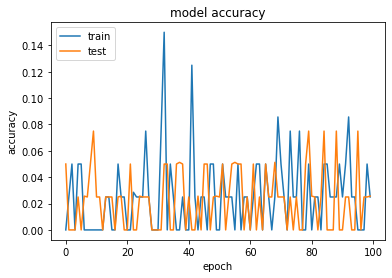

In [14]:
# Lets plot the results
print(history.history.keys())
# history accuracy
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

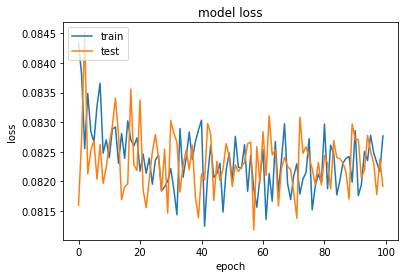

In [15]:
# history accuracy
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [16]:
# Lets predict
path = valDB + os.sep + "airport" + os.sep
imagesPredict = [f for f in listdir(path) if isfile(join(path,f))]

for file in imagesPredict:
    img = load_img(path + file, target_size=( 299, 299))
    tensorImage = img_to_array(img) /255.
    tensorImage = np.expand_dims(tensorImage, axis=0)
    prediction = model.predict(tensorImage, batch_size = 1)
    index = np.where(prediction[0] == max(prediction[0]))[0]
    if (0 != index[0].size):
        print("file "+ file + " is: " + classList[int(index[0])])

file airport_11_6_msrgb.jpg is: airport_terminal
file airport_11_7_msrgb.jpg is: airport_terminal
file airport_17_4_msrgb.jpg is: water_treatment_facility
file airport_25_0_msrgb.jpg is: hospital
file airport_3_5_msrgb.jpg is: water_treatment_facility


In [17]:
loadedModel = load_model("XceptionModel.h5")

path = valDB + os.sep + "airport" + os.sep
imagesPredict = [f for f in listdir(path) if isfile(join(path,f))]
# print(imagesPredict)


for file in imagesPredict:
    img = load_img(path + file, target_size=( 299, 299))
    tensorImage = img_to_array(img) /255.
    tensorImage = np.expand_dims(tensorImage, axis=0)
    prediction = loadedModel.predict(tensorImage, batch_size = 1)
    index = np.where(prediction[0] == max(prediction[0]))[0]
    if (0 != index[0].size):
        print("file "+ file + " is: " + classList[int(index[0])])

file airport_11_6_msrgb.jpg is: airport_terminal
file airport_11_7_msrgb.jpg is: airport_terminal
file airport_17_4_msrgb.jpg is: water_treatment_facility
file airport_25_0_msrgb.jpg is: hospital
file airport_3_5_msrgb.jpg is: water_treatment_facility
